### Notebook to be used to perform manual focus testing using ACCS Images. In this case we're taking the focus at a few different wavelengths to look at the focus shift as a fxn of wavelength for an on-axis image (0th order).

In [1]:
import numpy as np
from lsst.ts import salobj
import asyncio
from astropy.io import fits

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt
#%matplotlib ipympl
plt.rcParams['figure.figsize'] = [7, 6]

import numpy as np
import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.afw.display as afwDisplay
#afwDisplay.setDefaultBackend('firefly')
afwDisplay.setDefaultBackend('matplotlib')
import time
import datetime
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.geom

import os
import lsst.log
lsst.log.usePythonLogging()
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
logger = logging.getLogger('image_display_notebook')

In [2]:
import importlib
import utils.processExposure 
importlib.reload(utils.processExposure)
from utils.processExposure import processExposure

import utils.grabATImage 
importlib.reload(utils.grabATImage)
from utils.grabATImage import grabATImage

In [3]:
# Setup the butler
accs_images = True
if accs_images:
    repo = os.path.join("/home/saluser/ingest/accs/")#, mapper={'calibRoot': "/home/saluser/ingest/dmcs/CALIB"})
    butler = dafPersist.Butler(repo)
else:
    repo = os.path.join("/home/saluser/ingest/dmcs/")#, mapper={'calibRoot': "/home/saluser/ingest/dmcs/CALIB"})
    butler = dafPersist.Butler(repo)
#raw = butler.get("raw", visit=2019082600086)
#image = raw.getImage().array

2019-11-13 21:43:18,339 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-13 21:43:18,341 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


In [4]:
import lsst.daf.persistence as dafPersist
from lsst.daf.persistence import NoResults

In [5]:
#ATSpectrograph = salobj.Remote(SALPY_ATSpectrograph)
#
#
#ATSpectrograph = salobj.Remote(SALPY_ATSpectrograph)
d = salobj.Domain()

ATArchiver = salobj.Remote(d, 'ATArchiver')
await ATArchiver.start_task
ATCamera = salobj.Remote(d, 'ATCamera')
await ATCamera.start_task
#ATMonochromator = salobj.Remote(SALPY_ATMonochromator)
LinearStage1 = salobj.Remote(d, 'LinearStage',1)
await LinearStage1.start_task

2019-11-13 21:43:35,988 ATArchiver   INFO     Read historical data in 12.96 sec
2019-11-13 21:43:38,288 ATCamera     INFO     Read historical data in 0.01 sec
2019-11-13 21:43:39,746 LinearStage  INFO     Read historical data in 0.00 sec


In [6]:
#HeaderService = salobj.Remote(d, 'ATHeaderService')
#await HeaderService.start_task

### Leave this cell for state transitions 

In [7]:
#  bring into enable state if required
if False:
    try:
        await ATCamera.cmd_enable.start(timeout=15)
    except salobj.AckError as ack_err:
        print(f"Failed withs ack={ack_err.ackcmd.ack},ack.error={ack_err.ackcmd.error}, ackcmd.result={ack_err.ackcmd.result}")
else:
    print('Ignoring')
#asyncio.get_event_loop().run_until_complete(ATCamera.cmd_start.start())

Ignoring


## Setup Monochromator

In [8]:
wavelength = 455

In [9]:
# ATMonochromator.cmd_changeWavelength.set(wavelength=wavelength)
# try:
#     asyncio.get_event_loop().run_until_complete(ATMonochromator.cmd_changeWavelength.start())
# except AckError as ack_err:
#     print(f"Failed with ack.result={ack_err.ack.result}")

In [10]:
#ATMonochromator.cmd_selectGrating.set(gratingType=0)
#asyncio.get_event_loop().run_until_complete(ATMonochromator.cmd_selectGrating.start())

In [11]:
#ATMonochromator.cmd_changeSlitWidth.set(slitWidth=0.2,
#                          slit=SALPY_ATMonochromator.ATMonochromator_shared_Slit_FrontEntrance)
#asyncio.get_event_loop().run_until_complete(ATMonochromator.cmd_changeSlitWidth.start())

In [12]:
#ATMonochromator.cmd_changeSlitWidth.set(slitWidth=0.2,
#                          slit=SALPY_ATMonochromator.ATMonochromator_shared_Slit_FrontExit)
#asyncio.get_event_loop().run_until_complete(ATMonochromator.cmd_changeSlitWidth.start())

## Setup the Linear Stage (focuser)

In [13]:
pos=None
pos=await LinearStage1.tel_position.next(flush=True, timeout=5)
print('Current stage position is {:0.4f} [mm]'.format(pos.position))

Current stage position is 45.0000 [mm]


In [14]:
#await LinearStage1.evt_heartbeat.next(flush=True,timeout=10)

In [15]:
# Home the stage (only necessary if power was off)
if False:
    try:
        await LinearStage1.cmd_getHome.start(timeout=10)
    except salobj.AckError as ack_err:
        print(f"Failed withs ack={ack_err.ackcmd.ack},ack.error={ack_err.ackcmd.error}, ackcmd.result={ack_err.ackcmd.result}")
else:
    print('Ignoring')

Ignoring


In [13]:
# Put stage in position
lin_stage_pos=77.88-40# -11
lin_stage_pos=28.0 #27.5
LinearStage1.cmd_moveAbsolute.set(distance=lin_stage_pos)
try:
    await LinearStage1.cmd_moveAbsolute.start(timeout=20)
except salobj.AckError as ack_err:
    print(f"Failed withs ack={ack_err.ackcmd.ack},ack.error={ack_err.ackcmd.error}, ackcmd.result={ack_err.ackcmd.result}")


2019-11-13 21:43:51,664 LinearStage  WARNING  RemoteTelemetry(LinearStage, 1, position) falling behind; read 21 messages
2019-11-13 21:43:51,689 ATArchiver   WARNING  RemoteEvent(ATArchiver, 0, heartbeat) falling behind; read 12 messages
2019-11-13 21:43:51,707 LinearStage  WARNING  RemoteEvent(LinearStage, 1, heartbeat) falling behind; read 12 messages


In [14]:
pos=None
pos=await LinearStage1.tel_position.next(flush=True, timeout=5)
print('Current stage position is {:0.4f} [mm]'.format(pos.position))

Current stage position is 28.0000 [mm]


## Setup the Camera

In [15]:
#wavelength=632
group_id='wave,Focus,'+str(wavelength)+','+str(lin_stage_pos)+'PH=5um'
#group_id='Flat_455nm'
expTime=0.5

In [16]:
# Take image

#First flush events that we want to listen to
ATArchiver.evt_processingStatus.flush()
ATCamera.evt_endReadout.flush()

ATCamera.cmd_takeImages.set(expTime=expTime, shutter=1, numImages=1, imageType='OBJECT', groupId=group_id)

try:
    await ATCamera.cmd_takeImages.start(timeout=expTime+15)
except salobj.AckError as ack_err:
    print(f"Failed withs ack={ack_err.ackcmd.ack},ack.error={ack_err.ackcmd.error}, ackcmd.result={ack_err.ackcmd.result}")

endReadout = await ATCamera.evt_endReadout.next(flush=False, timeout=30)
print('ATCamera Wrote file {}'.format(endReadout.imageName) )
# wait for Archiver
test= await ATArchiver.evt_processingStatus.next(flush=False, timeout=30)
print(test.description)

ATCamera Wrote file AT_O_20191113_000038


TimeoutError: 

In [ ]:
#tmp = asyncio.get_event_loop().run_until_complete(ATArchiver.evt_processingStatus.next(flush=False, timeout=30))
#tmp.description

In [155]:
# parse out visitID from filename - this is highly annoying
tmp=endReadout.imageName.split('_')
prefix=tmp[2] # dayobs without the dashes

# Don't remember why I used int here... whitespace? 
# surely fixable but bigger fish.
suffix='{:05d}'.format(int(tmp[3].split('-')[0])) # SEQNUM, but need to trim extra 0 in obsid
visitID = int((prefix+suffix))
dataId1 = {'visit': visitID}
print('visitID is {}'.format(visitID))

# have to redefine butler after each image
butler = dafPersist.Butler(repo)
exposure = butler.get("raw", visit=visitID)
#image = raw.getImage().array

# do ISR correction
isr_corr_exposure = processExposure(exposure, repo=repo)
#isr_corr_exposure = exposure

2019-11-13 20:38:47,397 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-13 20:38:47,399 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


visitID is 2019111300037


2019-11-13 20:38:48,362 LsstCamAssembler WARNING  DataId(initialdata={'visit': 2019111300037}, tag=set()): amp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
2019-11-13 20:38:48,528 lsst.obs.lsst.translators.latiss WARNING  Explicit dark time not found, setting dark time to the exposure time.
2019-11-13 20:38:48,531 LsstCamAssembler WARNING  argDict[boresightAirmass] is None; stripping
2019-11-13 20:38:48,532 LsstCamMapper WARNING  Unable to set WCS for DataId(initialdata={'visit': 2019111300037}, tag=set()) from header as RA/Dec/Angle are unavailable
2019-11-13 20:38:48,532 CameraMapper WARNING  Cannot create SkyWcs using VisitInfo and Detector, using metadata-based SkyWcs: Cannot create SkyWcs from camera geometry: rotator angle defined using RotType=RotType.UNKNOWN instead of SKY.
2019-11-13 20:38:48,625 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-11-1

Time to perform image ISR was 2.065351 [s]


In [156]:
print(np.median(isr_corr_exposure.image.array))

40.779102


subarr Max value: 13050.4375
subarr Median value: 64.4378890991211
Full image Max value: 108081.328125
Full image Median value: 40.77910232543945


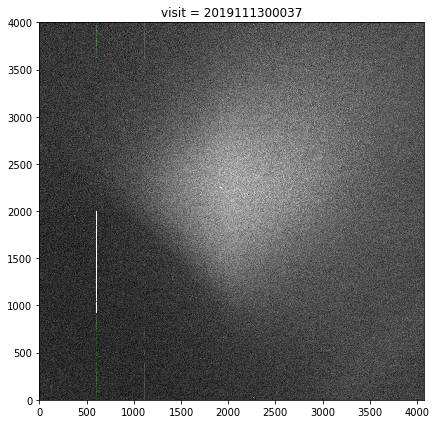

In [157]:
zeroth_order_estimate = lsst.geom.Point2D(2260,2050)
bbox0= lsst.geom.Box2I.makeCenteredBox(zeroth_order_estimate, lsst.geom.Extent2I(2500,2500))
peak0_subim = isr_corr_exposure.subset(bbox0)

#zeroth_order_estimate = lsst.geom.Point2D(2048,2048)
#bbox0= lsst.geom.Box2I.makeCenteredBox(zeroth_order_estimate, lsst.geom.Extent2I(2500,2500))

# zeroth_order_estimate = lsst.geom.Point2D(2110,2190)
# bbox0= lsst.geom.Box2I.makeCenteredBox(zeroth_order_estimate, lsst.geom.Extent2I(50, 50))
# peak0_subim = isr_corr_exposure.subset(bbox0)

if True: # display the image in firefly
    mag=1
    plt.rcParams['figure.figsize'] =  [7*mag, 6*mag] #[7, 6]
    plt.close('all')
    disp = afwDisplay.Display(2, reopenPlot=True)
    #disp.setMaskPlaneColor('SAT', afwDisplay.IGNORE)
    disp.setImageColormap('gray')
    disp.scale('linear', 'minmax')#'zscale')
    disp.mtv(peak0_subim, title='visit = {}'.format(visitID))    
   
    disp.scale('linear', 'zscale')#'zscale')
    disp.mtv(isr_corr_exposure, title='visit = {}'.format(visitID))

    #cgUtils.overlayCcdBoxes(isr_corr_exposure.getDetector(), isTrimmed=True, display=disp)
    print('subarr Max value: {}'.format(np.nanmax(peak0_subim.image.array)))
    print('subarr Median value: {}'.format(np.median(peak0_subim.image.array)))
    print('Full image Max value: {}'.format(np.nanmax(isr_corr_exposure.image.array)))
    print('Full image Median value: {}'.format(np.median(isr_corr_exposure.image.array)))

13050.4375


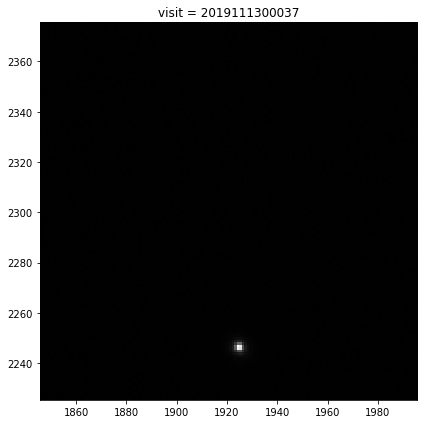

In [158]:
zeroth_order_estimate = lsst.geom.Point2D(1920,2300)
bbox0= lsst.geom.Box2I.makeCenteredBox(zeroth_order_estimate, lsst.geom.Extent2I(150,150))
peak0_subim = isr_corr_exposure.subset(bbox0)
#zeroth_order_estimate = lsst.geom.Point2D(2048,2048)
#bbox0= lsst.geom.Box2I.makeCenteredBox(zeroth_order_estimate, lsst.geom.Extent2I(1500,1500))
#peak0_subim = isr_corr_exposure.subset(bbox0)
if True: # display the image in firefly
    mag=1
    plt.rcParams['figure.figsize'] =  [7*mag, 6*mag] #[7, 6]
    plt.close('all')
    disp = afwDisplay.Display(2, reopenPlot=True)
    #disp.setMaskPlaneColor('SAT', afwDisplay.IGNORE)
    disp.setImageColormap('gray')
    disp.scale('linear', 'minmax')
    #disp.mtv(isr_corr_exposure, title='visit = {}'.format(visitID))
    disp.mtv(peak0_subim, title='visit = {}'.format(visitID))
    #cgUtils.overlayCcdBoxes(isr_corr_exposure.getDetector(), isTrimmed=True, display=disp)
    print(np.nanmax(peak0_subim.image.array))

In [159]:
if False: # display the image in firefly
    mag=1
    plt.rcParams['figure.figsize'] =  [7*mag, 6*mag] #[7, 6]
    plt.close('all')
    disp = afwDisplay.Display(2, reopenPlot=True)
    #disp.setMaskPlaneColor('SAT', afwDisplay.IGNORE)
    disp.setImageColormap('gray')
    disp.scale('linear', 'zscale')
    disp.mtv(isr_corr_exposure, title='visit = {}'.format(visitID))
    #cgUtils.overlayCcdBoxes(isr_corr_exposure.getDetector(), isTrimmed=True, display=disp)

In [160]:
np.median(isr_corr_exposure.image.array)

40.779102

In [161]:
# Source detection libraries
from lsst.meas.algorithms.detection import SourceDetectionTask
import lsst.afw.table as afwTable
start = time.time()

# create the output table for source detection
schema = afwTable.SourceTable.makeMinimalSchema()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 5  # detection threshold after smoothing

sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
# Find all sources in the image
tab = afwTable.SourceTable.make(schema)
#result = sourceDetectionTask.run(tab, isr_corr_exposure, sigma=2.1)

x=2050; y=2050
zeroth_order_estimate = lsst.geom.Point2D(x,y)
search_center_pt = lsst.geom.Point2D(zeroth_order_estimate.getX(),2000)
search_strip = lsst.geom.Box2I.makeCenteredBox(search_center_pt, lsst.geom.Extent2I(500,3999)) 
result = sourceDetectionTask.run(tab, isr_corr_exposure[search_strip], sigma=2.0)

end = time.time()
print('Time to perform Source finding was {0:2f} [s]'.format(end - start))

2019-11-13 20:38:56,493 sourceDetection INFO     Detected 3 positive peaks in 3 footprints and 0 negative peaks in 0 footprints to 5 sigma
2019-11-13 20:38:56,494 sourceDetection.background WARNING  Too few points in grid to constrain fit: min(nx, ny) < approxOrder) [min(4, 32) < 6]
2019-11-13 20:38:56,495 sourceDetection.background WARNING  Reducing approxOrder to 3
2019-11-13 20:38:56,552 sourceDetection INFO     Resubtracting the background after object detection


Time to perform Source finding was 0.478261 [s]


In [162]:
#result.extend(result2, deep=True)

In [163]:
#dir(result)

In [164]:
# Only here for me to debug, should be up top with other declarations
import importlib
import utils.findNarrowbandRonchiPeaks
importlib.reload(utils.findNarrowbandRonchiPeaks)
from utils.findNarrowbandRonchiPeaks import findNarrowbandRonchiPeaks

import utils.fitExposure
importlib.reload(utils.fitExposure)
from utils.fitExposure import fit2DGaussian

import utils.calc_encircled_energy
importlib.reload(utils.calc_encircled_energy)
from utils.calc_encircled_energy import calc_encircled_energy

import utils.calc_CofM
importlib.reload(utils.calc_CofM)
from utils.calc_CofM import calc_CofM

2019-11-13 20:39:01,311 findNarrowbandRonchiPeak_logger INFO     Zeroth order peak is at 1924, 2247
2019-11-13 20:39:01,312 findNarrowbandRonchiPeak_logger INFO     Dispersion set to None, returning only center source
2019-11-13 20:39:01,350 calc_CofM_logger INFO     x_CofM is 1924.4771603583122
2019-11-13 20:39:01,351 calc_CofM_logger INFO     y_CofM is 2246.426846584991
2019-11-13 20:39:01,352 calc_encirlced_energy_logger INFO     x_CofM is 1924.4771603583122
2019-11-13 20:39:01,352 calc_encirlced_energy_logger INFO     y_CofM is 2246.426846584991


<Gaussian2D(amplitude=14403.0217856, x_mean=1924.4165398, y_mean=2246.56218936, x_stddev=1.07939645, y_stddev=1.11592477, theta=0.)>


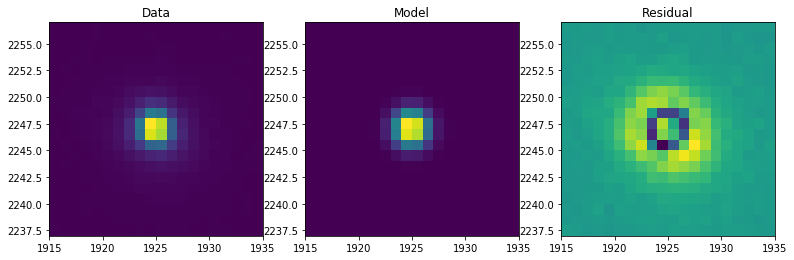

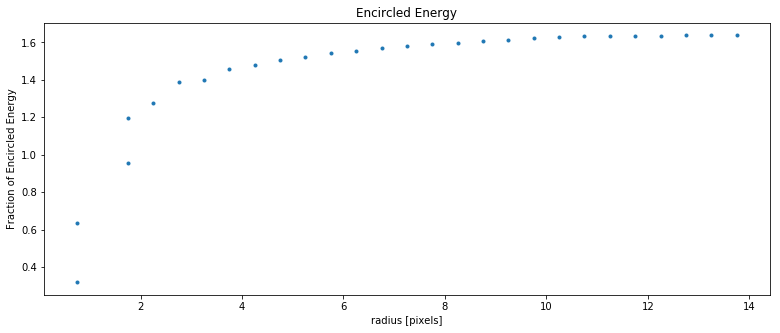

2019-11-13 20:39:01,864 calc_encirlced_energy_logger INFO     EE radius at 50%, 67% and 80% is [0.750, 0.854, 1.262] pixels


Max value in subim is 12952.927734375


In [165]:
# estimate place of zeroth order
#zeroth_order_estimate = lsst.geom.Point2D(2281,1930)
zeroth_order_estimate = lsst.geom.Point2D(2075,2025) # low res grating
zeroth_order_estimate = lsst.geom.Point2D(2010,2175) #empty (632)
zeroth_order_star_BBox= lsst.geom.Box2I.makeCenteredBox(zeroth_order_estimate, lsst.geom.Extent2I(200,200)) 

# Find the correct sources
zeroth_order_star_BBox = lsst.geom.Box2I.makeCenteredBox(zeroth_order_estimate, lsst.geom.Extent2I(400,400)) 
# wavelength solution is bad for the fiberSpectrograph, but close enough for this to work
# can use the monochromator wavelength which is better, but that's not the correct way in the long run
wavelength = wavelength
dispersion = (1/0.6358) # pixels/nm
spectral_position_angle=0.0107 # radians clockwise from top

# Find +/- 1 order peaks 
sources = result.sources
#center_source, peak1, peak2 = findNarrowbandRonchiPeaks(sources, zeroth_order_star_BBox, wavelength, dispersion, spectral_position_angle)

dispersion=None
center_source = findNarrowbandRonchiPeaks(sources, zeroth_order_star_BBox, wavelength, dispersion, spectral_position_angle)

# Fit peaks
# zeroth order
# variables names are weird here because I can't think of a clever way to have -1 and +1 as variable names

bbox0 = lsst.geom.Box2I.makeCenteredBox(center_source.getFootprint().getCentroid(), lsst.geom.Extent2I(20,20)) 
peak0_subim = isr_corr_exposure.subset(bbox0)
p0, x0 , y0 = fit2DGaussian(peak0_subim, plot=True)
p0_x_CofM, p0_y_CofM = calc_CofM(peak0_subim) # 2167,3372

# Calculate EE and CofM
p0_EE_rad50_pix, p0_EE_rad67_pix, p0_EE_rad80_pix = calc_encircled_energy(peak0_subim, plot=True) 
#
print('Max value in subim is {}'.format(np.max(peak0_subim.image.array)))

In [166]:
# 35mm, 21 pix EE80
# 33mm, 22.2 pixel
# 37 mm, 19.1
# 39 mm, 16.8
# 41mm, 14.3
# 43mm, 11.636
# 45mm, 9.0 pix?
#--- new 5um pinhole
# 30mm, 3.85pix
# 32mm, 5.18

In [ ]:
if True: # display the image in firefly
    mag=2
    plt.rcParams['figure.figsize'] =  [7*mag, 6*mag] #[7, 6]
    plt.close('all')
    disp = afwDisplay.Display(2, reopenPlot=True)
    #disp.setMaskPlaneColor('SAT', afwDisplay.IGNORE)
    disp.setImageColormap('gray')
    disp.scale('linear', 'zscale')
    disp.mtv(peak0_subim, title='visit = {}'.format(visitID))
    #cgUtils.overlayCcdBoxes(isr_corr_exposure.getDetector(), isTrimmed=True, display=disp)

In [133]:
pup_diam=25e-3; wave=455e-9
f_coll=113e-3; 

f_tel=550e-3 # 400mm nominal - measured around 25-26 inches
pinhole_diam=5e-6
pix_scl=10 # [um/pix]

diff_limit=1e6*wave/pup_diam*f_coll
print('Diffraction Limit in object space (f=125mm, D=25mm, wave={0:0.1f}nm) is: {1:3f} [um]'
      .format(wave*1e9, diff_limit))
mag=f_tel/f_coll
print('Image diameter of Diffraction Limit is: {0:3f} [um]'.format(mag*diff_limit/pix_scl))
print('Magnification is f_tel/f_col {}:'.format(mag))
im_size=1e6*mag*pinhole_diam
print('Expected image diameter for {0:3f} diameter pinhole: {1:3f} [um]'.format(pinhole_diam*1e6, im_size))
print('80% EE radius in pixels ~{}'.format(im_size/2/pix_scl))

Diffraction Limit in object space (f=125mm, D=25mm, wave=455.0nm) is: 2.056600 [um]
Image diameter of Diffraction Limit is: 1.001000 [um]
Magnification is f_tel/f_col 4.867256637168142:
Expected image diameter for 5.000000 diameter pinhole: 24.336283 [um]
80% EE radius in pixels ~1.2168141592920356
